Containers
==========

**What are containers?**

OS-level virtualization of software in a fully functional, portable and isolated form. Docker is commonly use for containerization.

**Install**

[Docker Desktop](https://docs.docker.com/desktop/) vs [Docker Engine](https://docs.docker.com/engine/)

**Docker [hub](https://hub.docker.com/)**

If using Docker Desktop, create account and authenticate.

**Examples**:

- [Hello world](https://hub.docker.com/_/hello-world)

  > `$ docker run hello-world`

- Specific version of [Python](https://hub.docker.com/_/python)

  > `$ docker pull docker pull python:3.13.1-slim-bullseye`
  > `$ docker run -it python:3.13.1-slim-bullseye`
  > `$ docker run -it python:3.13.1-slim-bullseye bash`

- [Model example](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) in Python 3.13.

  * The code: train logistic regression on breast cancer dataset
  * Add requirements
  * Create `Dockerfile`
  * Build `docker build -t mymodel .`
  * Test `docker run -it mymodel python model.py`
  * More: Make a prediction application for clinical data









Multicolinearity
================

* Non-identifiability
* Post-treatment bias


In [ ]:
!pip install git+https://github.com/BirkhoffG/causalgraphicalmodels.git

  Cloning https://github.com/BirkhoffG/causalgraphicalmodels.git to /tmp/pip-req-build-ndhyujig
  Running command git clone --filter=blob:none --quiet https://github.com/BirkhoffG/causalgraphicalmodels.git /tmp/pip-req-build-ndhyujig
  Resolved https://github.com/BirkhoffG/causalgraphicalmodels.git to commit cd178afc246160d1d0ec996a4ec0652cba580205
  Preparing metadata (setup.py) ... done
  Created wheel for causalgraphicalmodels: filename=causalgraphicalmodels-0.0.5-py3-none-any.whl size=10533 sha256=ebbc5d902e1bcb838c61a675356904341df5498609ffdc81fdd1e167f3e429c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jrb8c21c/wheels/9d/19/42/dc1111d6ae65b86d03b7fff1cb06fdc8bc08bacdaf49c2e2ed
Successfully built causalgraphicalmodels


In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm
import seaborn as sns

import arviz as az ## This is new, but it is installed along with PyMC

## This is new for working with DAGs, you will have to install it
## uncomment the next box and run it
import causalgraphicalmodels as cgm
from causalgraphicalmodels import CausalGraphicalModel


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions
    except for the last index parameters while the last (rightmost)
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    ## quantile(x, [(1 - prob)/2, (1 + prob)/2], axis=-1)
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


## Multicolinear legs example

The simulation example is predicting an individual's height (H) using the length of their legs (L and R) as predictor variables. Surely height is positively associated with leg length, or at least the simulation will assume it is.

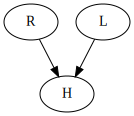

In [ ]:
CausalGraphicalModel(
    nodes=['L', 'R', 'H'], edges=[('L', 'H'), ('R', 'H')]
).draw()

### Simulated example

Let's simulate the heights and leg lengths of 100 individuals. For each, first a height is simulated from a Gaussian distribution. Then each individual gets a simulated proportion of height for their legs, ranging from 0.4 to 0.5. Finally, we add measurement or developmental error, so the left and right legs are not exactly the same length, as is typical in real populations.

In [ ]:
N = 100
height = normal(10, 2, N)
leg_prop = linspace(0.4, 0.5, N)
leg_left = leg_prop*height + normal(0, 0.02, N)
leg_right = leg_prop*height + normal(0, 0.02, N)

### Multiple linear regression

Now we imagine that this is a real dataset and that we want to use multiple regression to study the height predicted by the height of both legs
\begin{align*}
H_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_{L}L_i + \beta_{R}R_i \\
\alpha &\sim \text{Normal}(10, 100) \\
\beta_L &\sim \text{Normal}(2, 10) \\
\beta_R &\sim \text{Normal}(2, 10) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
Note that just like the book, we are using "...very vague, bad priors here, just so that we can be sure that the priors aren't responsible for what is about to happen."

In [ ]:
with pm.Model() as model_H_LR:
    sigma = pm.Exponential('sigma', 1)
    beta_L = pm.Normal('beta_L', mu=2, sigma=10)
    beta_R = pm.Normal('beta_R', mu=2, sigma=10)
    alpha = pm.Normal('alpha', mu=10, sigma=100)
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    _mu = alpha + beta_L*leg_left + beta_R*leg_right
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H = pm.Normal('height', mu=mu, sigma=sigma, observed=height)
    ## MCMC
    _H_LR_posterior = pm.sample(1000, tune=1000, chains=2, cores=2)
H_LR_posterior = _H_LR_posterior.posterior.to_dataframe()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.770,0.509,-0.204,1.687,0.017,0.012,934.0,692.0,1.0
beta_L,0.029,3.095,-5.555,5.958,0.120,0.085,670.0,895.0,1.0
beta_R,2.025,3.086,-3.754,7.720,0.119,0.084,675.0,774.0,1.0
sigma,0.706,0.073,0.584,0.850,0.002,0.002,827.0,622.0,1.0


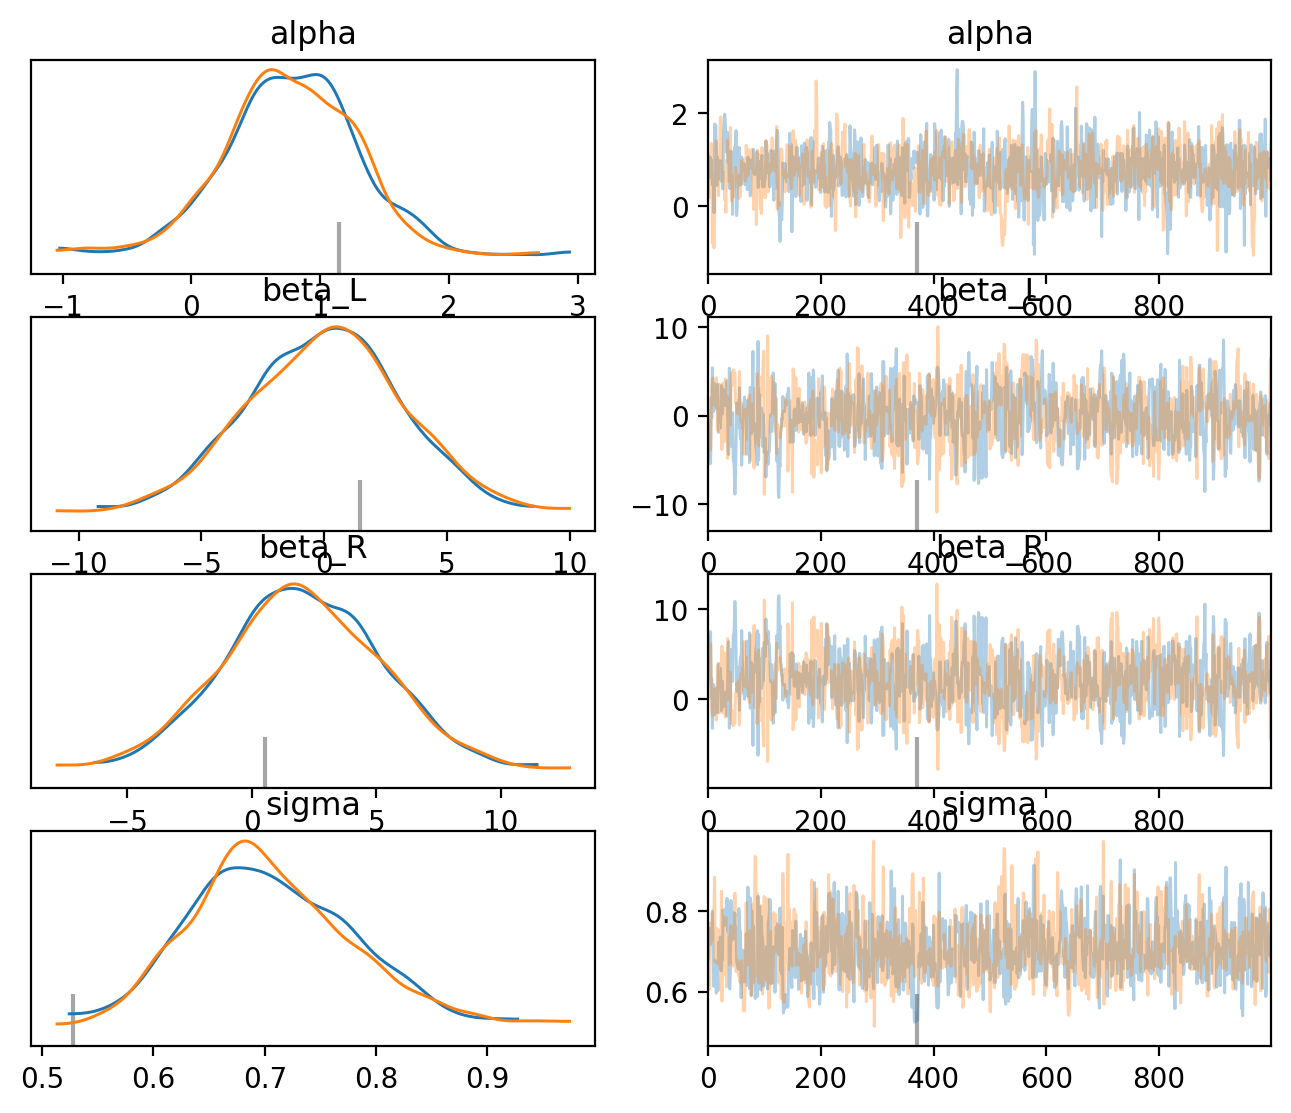

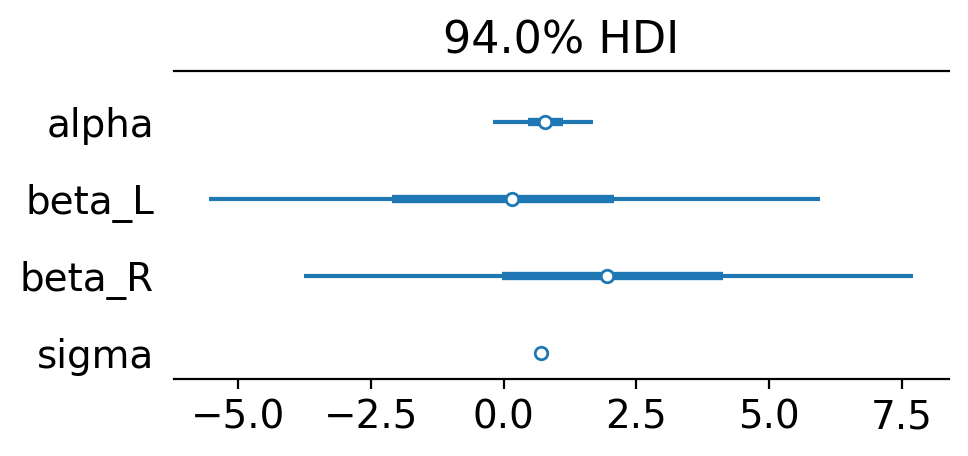

In [ ]:
varnames = ['alpha', 'beta_L', 'beta_R', 'sigma']
display(pm.summary(_H_LR_posterior, var_names=varnames))
az.plot_trace(_H_LR_posterior, varnames, compact=False, figsize=(8, 1.6*len(varnames)));
az.plot_forest(_H_LR_posterior, var_names=["~mu"], combined=True, figsize=[5, 2]);

The variability for $\beta_L$  and  $\beta_R$  is unusually large.

Question answered for multiple linear regression:

> What is the value of knowing each predictor, after already knowing all of the other predictors? (What is the value of knowing each leg's length, after already knowing the other leg's length?)

If the predictprs are highly correlated, then the model becomes

$$\mu_i = \alpha + \beta_{L}L_i + \beta_{R}R_i \approx \alpha + \beta_{L}L_i + \beta_{R}L_i = \alpha + (\beta_{L} + \beta_{R})L_i .$$

The model is telling us that we know $\beta_L + \beta_R$ very well. But there are infinite compinations of $\beta_L$ and $\beta_R$ that produce the same sum.

A simple scatter plot of the posterior samples shows that the two parameters are negatively correlated. And plot of the posterior distribution of the sum of the two parameters shows the proper association of either leg with height. It shows that $\beta_L + \beta_R \approx 2$.

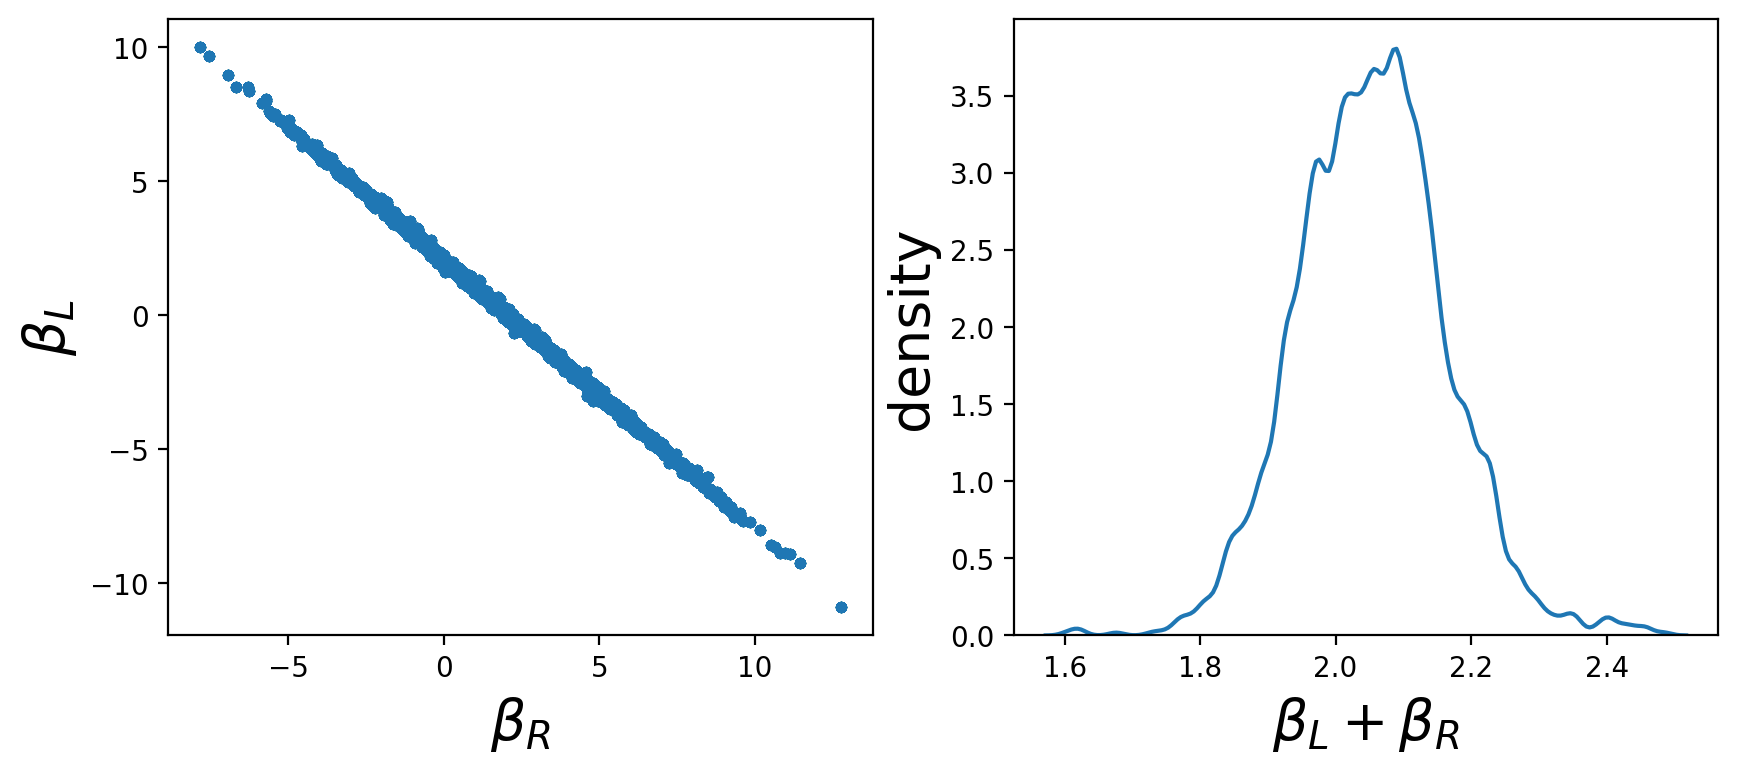

In [ ]:
fig = figure(1, [10, 4])

fig.add_subplot(121)
plot(H_LR_posterior['beta_R'], H_LR_posterior['beta_L'], '.')
xlabel(r'$\beta_R$', fontsize=20)
ylabel(r'$\beta_L$', fontsize=20);

fig.add_subplot(122)
sns.kdeplot(H_LR_posterior['beta_L'] + H_LR_posterior['beta_R'], label=r'$\beta_L + \beta_R$')
xlabel(r'$\beta_L + \beta_R$', fontsize=20)
ylabel('density', fontsize=20);

### Single linear regression

Let's compare to the single variable regression.

In [ ]:
with pm.Model() as model_H_L:
    sigma = pm.Exponential('sigma', 1)
    beta_L = pm.Normal('beta_L', mu=2, sigma=10)
    alpha = pm.Normal('alpha', mu=10, sigma=100)
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    _mu = alpha + beta_L*leg_left
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H = pm.Normal('height', mu=mu, sigma=sigma, observed=height)
    ## MCMC
    _H_L_posterior = pm.sample(1000, tune=1000, chains=2, cores=2)
H_L_posterior = _H_L_posterior.posterior.to_dataframe()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.715,0.500,-0.148,1.712,0.020,0.015,599.0,759.0,1.0
beta_L,2.064,0.108,1.860,2.259,0.004,0.003,596.0,747.0,1.0
sigma,0.706,0.074,0.563,0.837,0.002,0.002,957.0,815.0,1.0


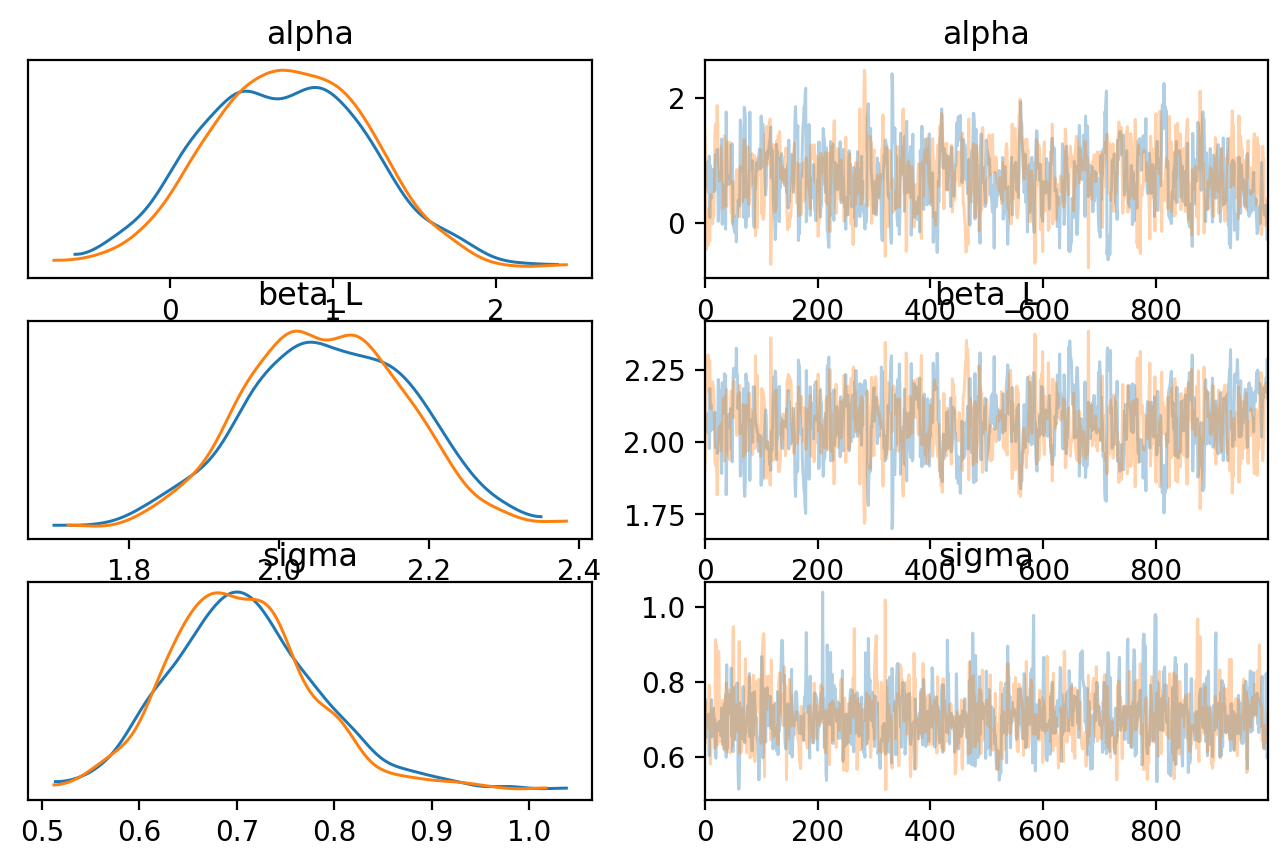

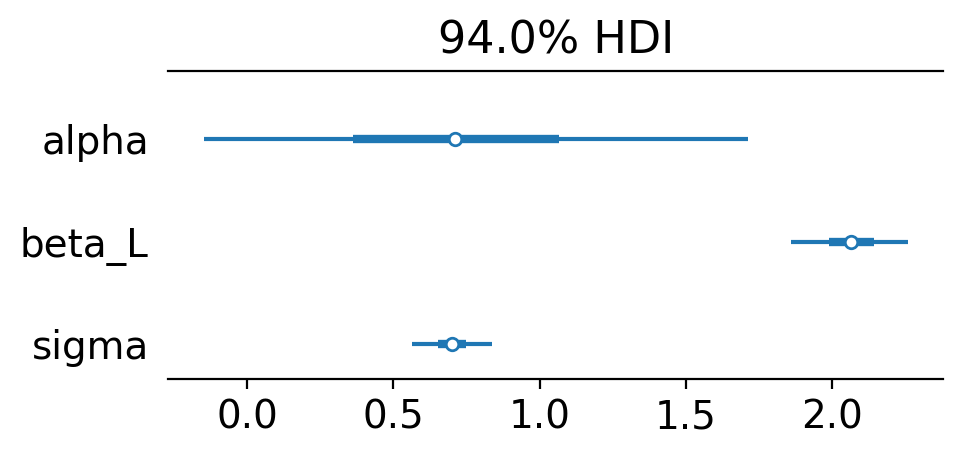

In [ ]:
varnames = ['alpha', 'beta_L', 'sigma']
display(pm.summary(_H_L_posterior, var_names=varnames))
az.plot_trace(_H_L_posterior, varnames, compact=False, figsize=(8, 1.6*len(varnames)))
az.plot_forest(_H_L_posterior, var_names=["~mu"], combined=True, figsize=[5, 2]);

Let's plot of the parameter posterior densities for $\beta_L + \beta_R$ and $\beta_L - \beta_R$.
We also show a density for $\beta_L$ from the single variable regression we did above. This matches very well with $\beta_L + \beta_R$ from the two variable regression.
The second density plot for $\beta_L - \beta_R$ shows **much** more variability (look at the range of credible values). In fact, I'm not sure the Gaussian-like distribution is accurate here; remember, MCMC only gives us approximations, and they can sometimes fail.

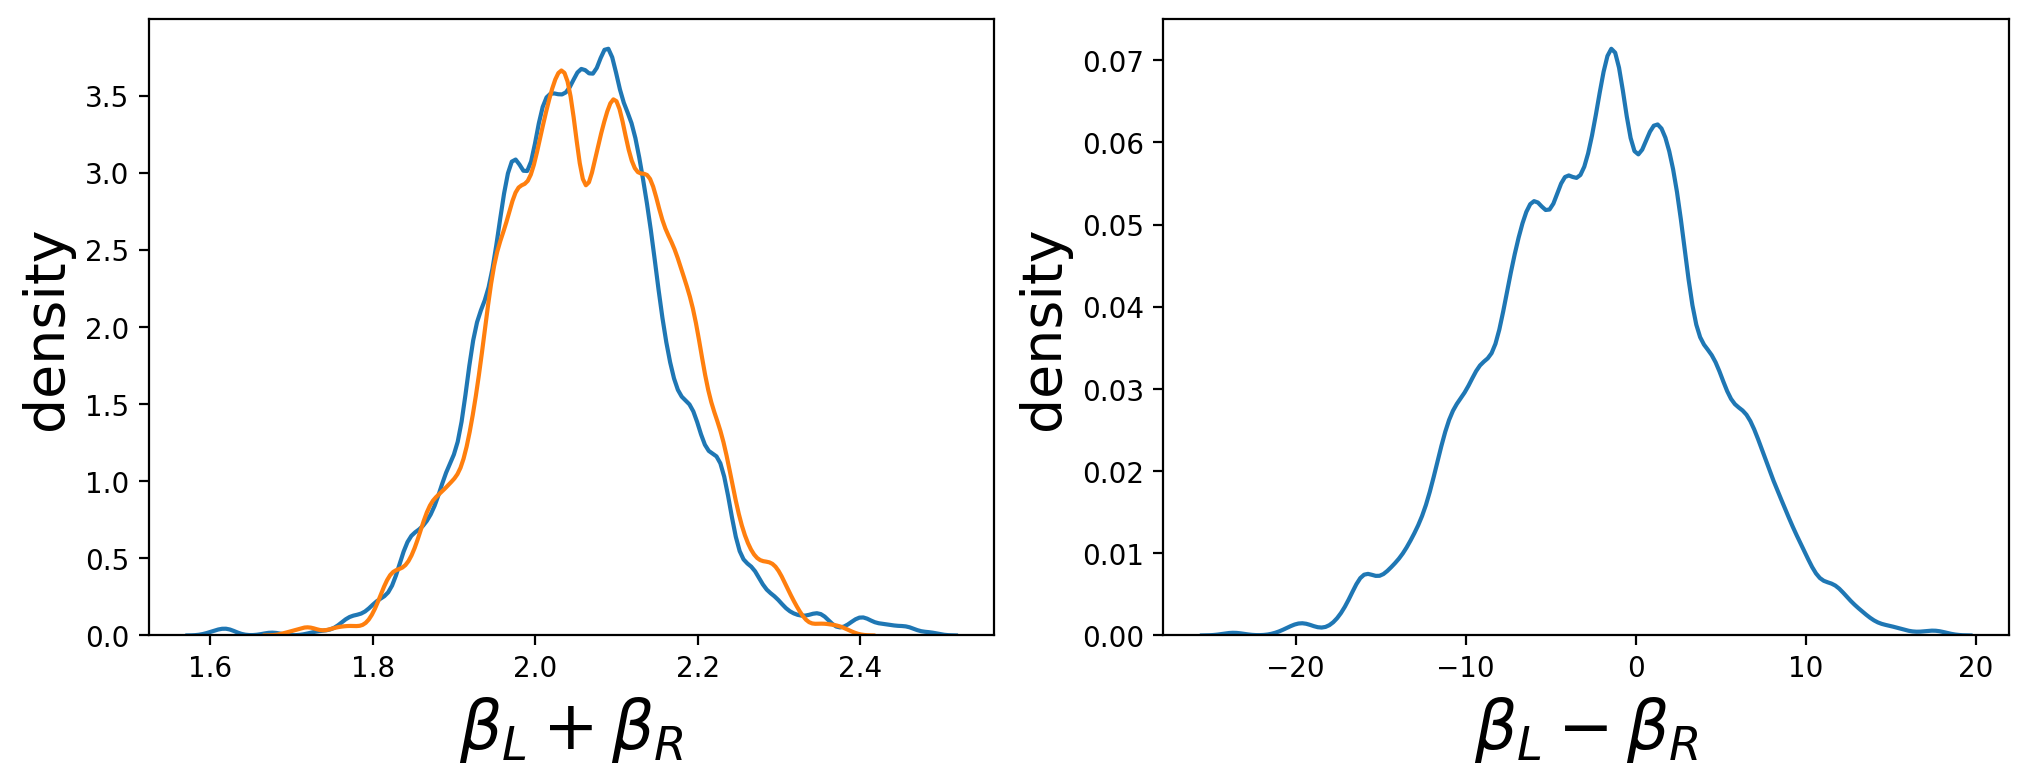

In [ ]:
fig = figure(1, [12, 4])

fig.add_subplot(121)
sns.kdeplot(H_LR_posterior['beta_L'] + H_LR_posterior['beta_R'], label='multi reg')
sns.kdeplot(H_L_posterior['beta_L'], label='single reg')
xlabel(r'$\beta_L + \beta_R$', fontsize=20)
ylabel('density', fontsize=20);

fig.add_subplot(122)
sns.kdeplot(H_LR_posterior['beta_L'] - H_LR_posterior['beta_R'])
xlabel(r'$\beta_L - \beta_R$', fontsize=20)
ylabel('density', fontsize=20);

### Summary:

The weird variability in the posterior for $\beta_L$ and $\beta_R$ stems from the model's inability to determine $\beta_L - \beta_R$ from the data.
This is an example of **non-identifiability.**

The height is conditionally independent both ways:
  1. given $L$, $R$ gives no additional information about $H$. $p(H | L, R) = p(H | L)$
  2. given $R$, $L$ gives no additional information about $H$. $p(H | L, R) = p(H | R)$

## Plant growth example

**Effect of anti-fungal soil treatment on plant growth.**

You want to know the difference in growth under different anti-fungal soil treatments, because fungus on the plants tends to reduce their growth. Plants are initially seeded and sprout. Their heights are
measured. Then different soil treatments are applied. Final measures are the height of the plant and the presence of fungus. There are four variables of interest here: initial height (H0), final height (H1), treatment (T), and presence of fungus (F). Final height is the outcome of interest.


We want to show that the treatment has a positive effect on plant growth.

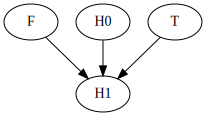

In [ ]:
CausalGraphicalModel(
    nodes=['H0', 'H1', 'F', 'T'],
    edges=[('H0', 'H1'), ('F', 'H1'), ('T', 'H1')]
).draw()

### Simulated example

In [ ]:
N = 100
height_initial = normal(10, 2, N)
treatment = ones(N)
treatment[:N//2] = 0 ## integer division N//2 will always return an integer (insteaed of float)
## if the treatment is present (value = 1) then the probability of fungus is 0.1
## otherwise, if treatment=0, then the fungus is present with probability 0.5
fungus = stats.bernoulli.rvs(p=0.5 - treatment*0.4, size=N)
height_t1 = normal(height_initial + 5 - 3*fungus, 1, N)

We will assume the above is a real dataset and build some models.

### Linear model (simple)

First, let's see what $H_0$ by itself tells us about $H_1$. $p$ is a parameter measuring the proportion of $H_0$ that $H_1$ is, $p=H_1/H_0$.
- If $p = 1$, the plant hasn't changed at all from time t = 0 to time t = 1.
- If $p = 2$, it has doubled in height.
Use Log-Normal distribution ($p>0$ and centered at 1).

\begin{align*}
h_{1,i} & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = h_{0,i} p \\
p & \sim \text{LogNormal}(0, 0.25) \\
\sigma & \sim \text{Exp}(1)
\end{align*}

In [ ]:
with pm.Model() as model_H1_H0:
    sigma = pm.Exponential('sigma', 1)
    p = pm.Lognormal('p', mu=0, sigma=0.25) ## always positive
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0_posterior = pm.sample(1000, tune=1000, cores=4)
H1_H0_posterior = _H1_H0_posterior.posterior.to_dataframe()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.386,0.020,1.349,1.424,0.000,0.000,4254.0,2684.0,1.0
sigma,2.043,0.145,1.774,2.310,0.002,0.002,3921.0,2707.0,1.0


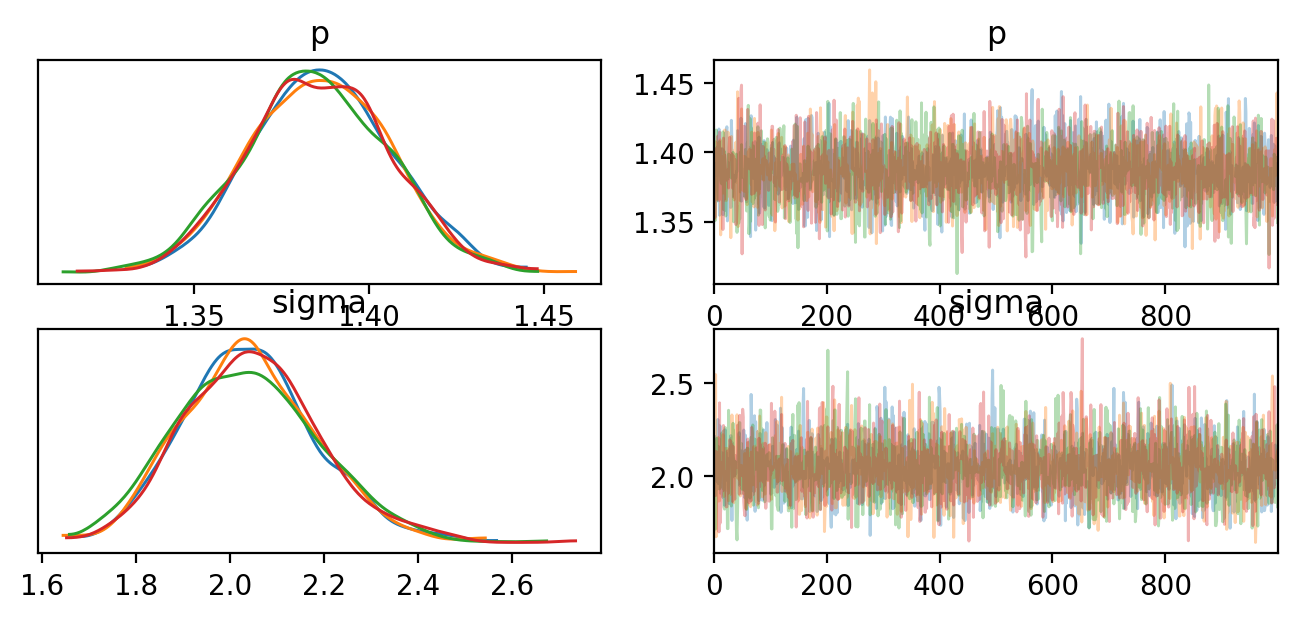

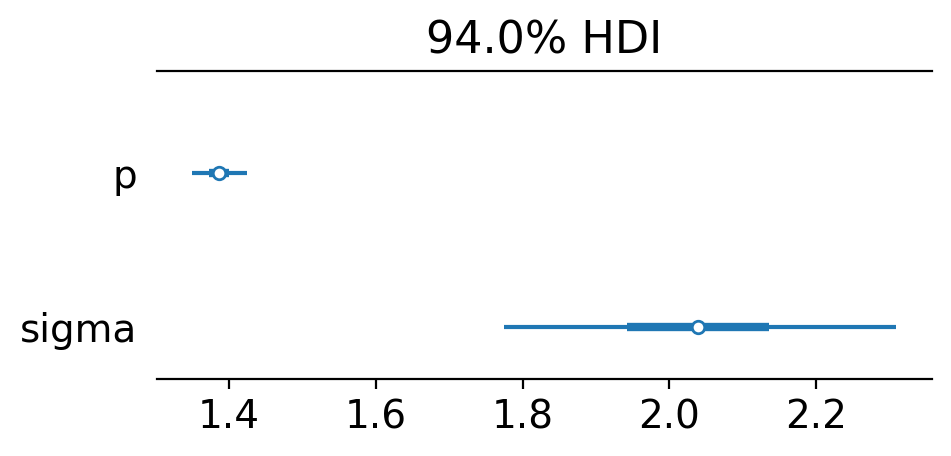

In [ ]:
var_names = ['p', 'sigma']
display(pm.summary(_H1_H0_posterior, var_names=var_names))
az.plot_trace(_H1_H0_posterior, var_names, compact=False, figsize=(8, 1.6*len(var_names)))
az.plot_forest(_H1_H0_posterior, var_names=["~mu"], combined=True, figsize=[5, 2]);

About 40% growth, on average.

### Linear model (treatment and fungus)

Now to include the treatment and fungus variables. We'll include both of them, following the notion that we'd like to measure the impact of both the treatment and the fungus itself.

\begin{align*}
h_{1,i} & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = h_{0,i} p \\
p & =\alpha +\beta_T T_i + \beta_F F_i \\
\alpha & \sim \text{LogNormal}(0, 0.25)\\
\beta_T & \sim \text{Normal}(0, 0.5)\\
\beta_F & \sim \text{Normal}(0, 0.5)\\
\sigma & \sim \text{Exp}(1)
\end{align*}


In [ ]:
with pm.Model() as model_H1_H0TF:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Lognormal('alpha', mu=0, sigma=0.25)
    beta_T = pm.Normal('beta_T', mu=0, sigma=0.5)
    beta_F = pm.Normal('beta_F', mu=0, sigma=0.5)
    p = pm.Deterministic('p', alpha + beta_T*treatment + beta_F*fungus)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0TF_posterior = pm.sample(1000, tune=1000, cores=4)
H1_H0TF_posterior = _H1_H0TF_posterior.posterior.to_dataframe()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_T,0.028,0.031,-0.029,0.086,0.001,0.000,2328.0,2609.0,1.0
beta_F,-0.297,0.034,-0.363,-0.233,0.001,0.001,2365.0,2552.0,1.0
alpha,1.456,0.025,1.410,1.503,0.001,0.000,2046.0,2215.0,1.0
sigma,1.439,0.102,1.245,1.624,0.002,0.001,2893.0,2467.0,1.0


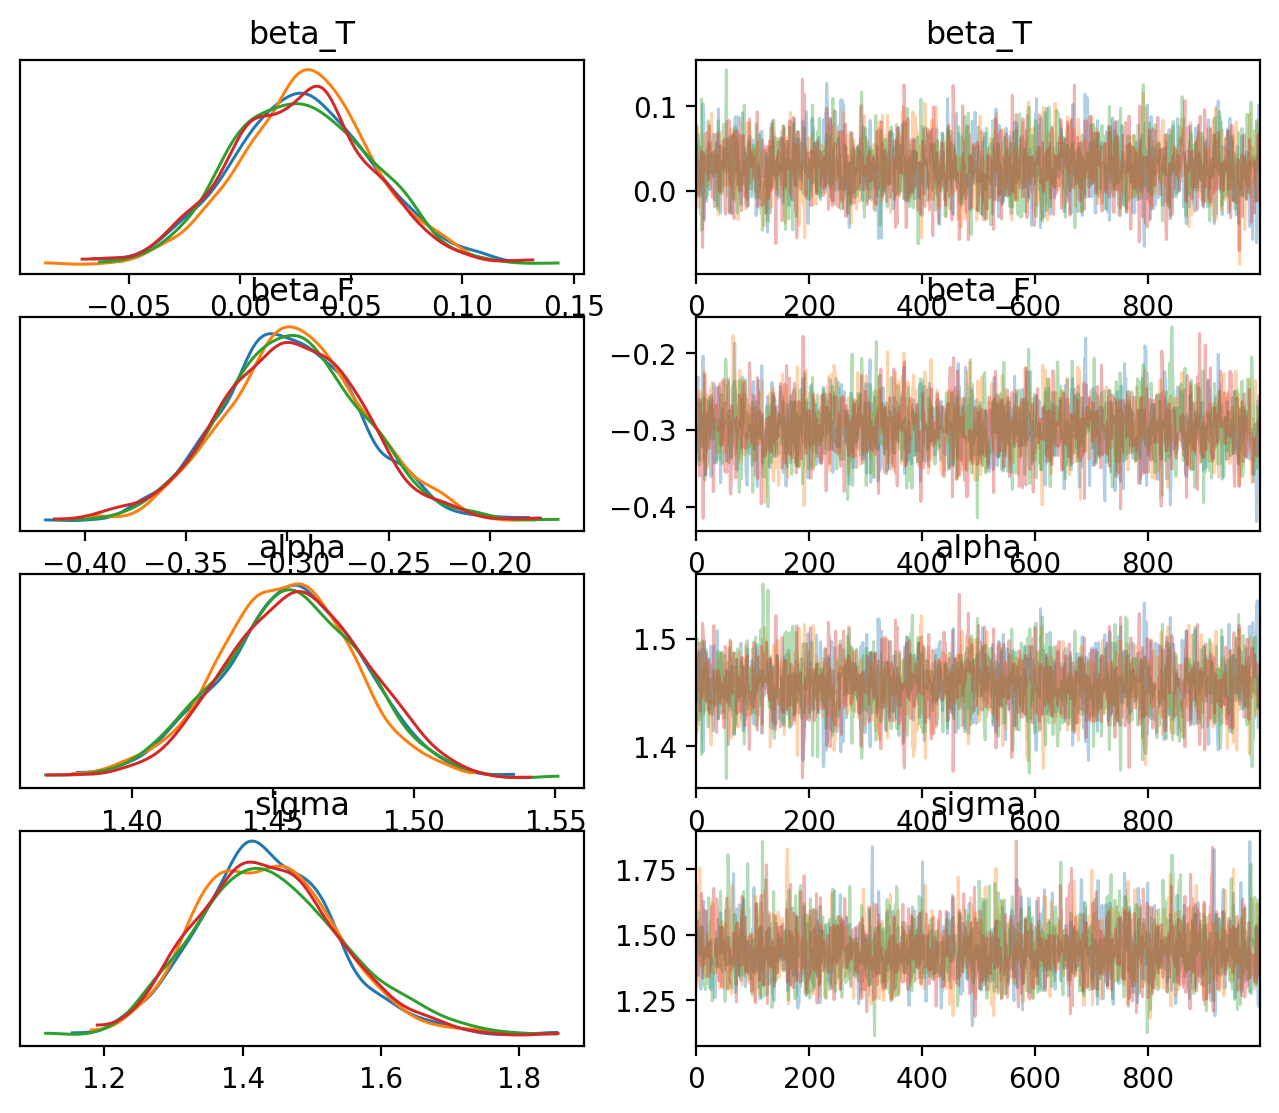

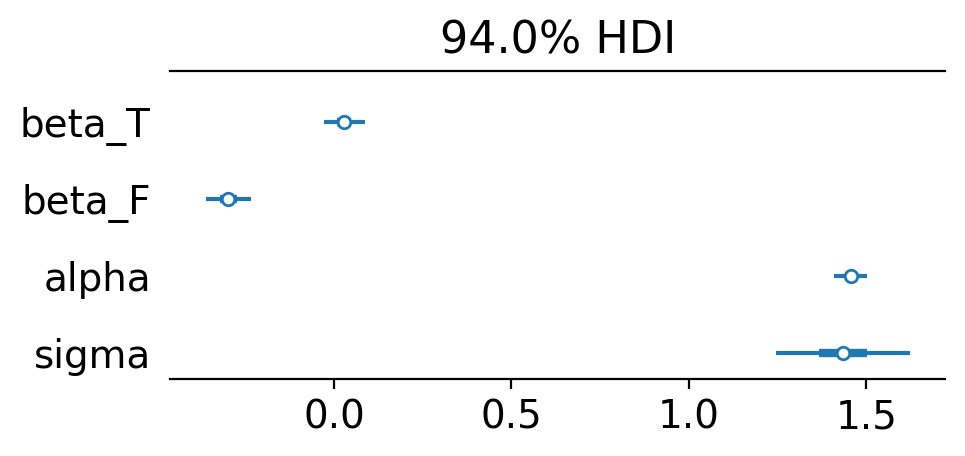

In [ ]:
var_names = ['beta_T', 'beta_F', 'alpha', 'sigma']
display(pm.summary(_H1_H0TF_posterior, var_names=var_names))
az.plot_trace(_H1_H0TF_posterior, var_names, compact=False, figsize=(8, 1.6*len(var_names)))
az.plot_forest(_H1_H0TF_posterior, var_names=var_names, combined=True, figsize=[5, 2]);


The mean of $\beta_T$ is near zero and small credible interval.

**The model is telling us that if we know $F$ then $T$ tells us nothing about growth.**

If we misinterpret this, it seems to tell us that treatment has no effect on growth.
But really it is telling us that once we know if fungus is present, knowing if the treatment was given tells us nothing about the growth.
This is because the treatment inhibits fungal growth, so if we see fungal growth then presumably the treatment was either not given or was ineffective.


If we condition on $F$ we make $H_1$ independent of $T$

...we block the path from $T$ to $H_1$

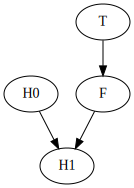

In [ ]:
anti_fungal = CausalGraphicalModel(
    nodes=['H0', 'H1', 'F', 'T'], edges=[('H0', 'H1'), ('F', 'H1'), ('T', 'F')]
)
anti_fungal.draw()

We can show the conditional independencies implied by the graph

In [ ]:
all_independencies = anti_fungal.get_all_independence_relationships()
for s in all_independencies:
    if 'H1' in [s[0], s[1]]: ## Print only the independencies involving H1
        print(s[0], 'is independent of', s[1], 'given', s[2])

H1 is independent of T given {'F'}
H1 is independent of T given {'F', 'H0'}


### Linear model (treatment only)

So we should not use $F$ in our model?

Let's try

\begin{align*}
h_{1,i} & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = h_{0,i} p \\
p & =\alpha +\beta_T T_i \\
\alpha & \sim \text{LogNormal}(0, 0.25)\\
\beta_T & \sim \text{Normal}(0, 0.5)\\
\sigma & \sim \text{Exp}(1)
\end{align*}

In [ ]:
with pm.Model() as model_H1_H0T:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Lognormal('alpha', mu=0, sigma=0.25)
    beta_T = pm.Normal('beta_T', mu=0, sigma=0.5)
    p = pm.Deterministic('p', alpha + beta_T*treatment)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0T_posterior = pm.sample(1000, tune=1000, cores=4)
H1_H0T_posterior = _H1_H0T_posterior.posterior.to_dataframe()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_T,0.150,0.037,0.077,0.217,0.001,0.001,2268.0,2596.0,1.0
alpha,1.314,0.026,1.265,1.362,0.001,0.000,2113.0,2407.0,1.0
sigma,1.903,0.136,1.646,2.158,0.002,0.002,3060.0,2733.0,1.0


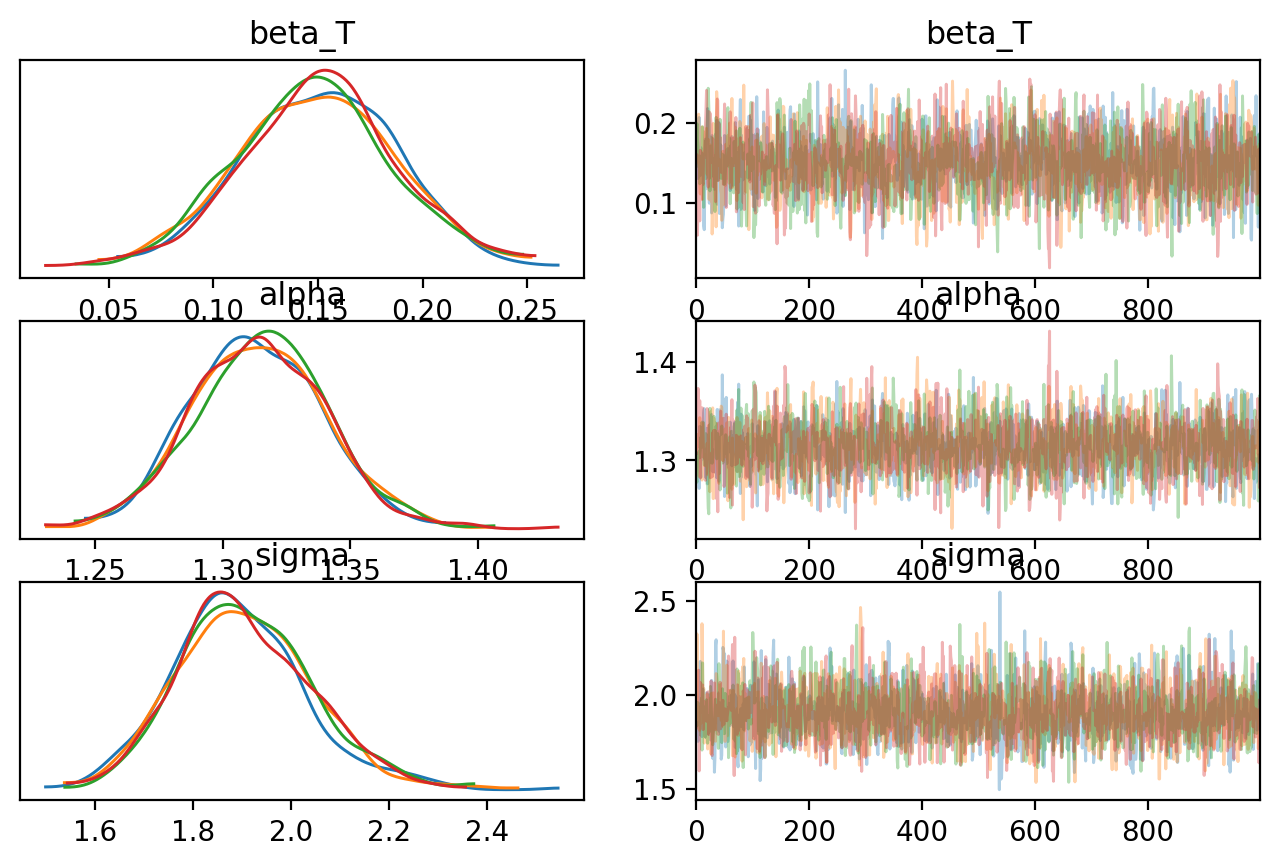

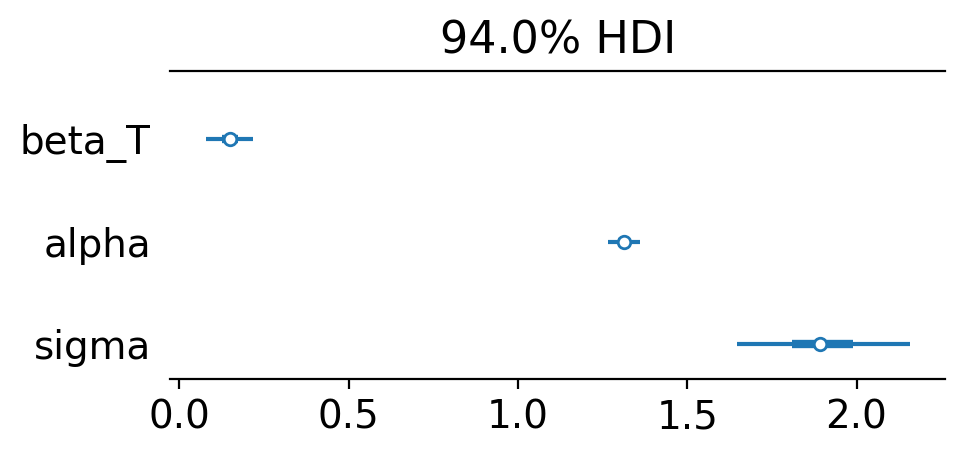

In [ ]:
var_names = ['beta_T', 'alpha', 'sigma']
display(pm.summary(_H1_H0T_posterior, var_names=var_names))
az.plot_trace(_H1_H0T_posterior, var_names, compact=False, figsize=(8, 1.6*len(var_names)))
az.plot_forest(_H1_H0T_posterior, var_names=var_names, combined=True, figsize=[5, 2]);

The above shows that once we remove the conditioning on the presence of fungus, our model shows a positive effect of the treatment on growth

### Summary:

Conditioning on $F$ closes the path between $H_1$ and $T$. Fungus is a **post-treatment variable**.

So when we control for fungus, the model is implicitly answering the question: Once we already know whether or not a plant developed fungus, does soil treatment matter? The answer is “no,” because soil treatment has its effects on growth through reducing fungus. But we actually want to know, based on the design of the experiment, is the impact of treatment on growth. To measure
this properly, we should omit the post-treatment variable fungus.

## Plant growth example (revised)

Example: Anti-fungal soil treatment: Version 2

Let's change the plant growth model slightly so that fungal growth has no effect on plant growth and add in the unobserved effect of moisture $M$.

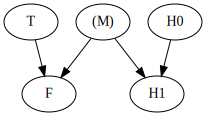

In [ ]:
anti_fungal2 = CausalGraphicalModel(
    nodes=['H0', 'H1', 'F', 'T', '(M)'], edges=[('H0', 'H1'), ('T', 'F'), ('(M)', 'H1'), ('(M)', 'F')]
)
anti_fungal2.draw()

### Simulated example

Include moisture.

In [ ]:
N = 100
height_initial = normal(10, 2, N)
treatment = ones(N)
treatment[:N//2] = 0
moisture = stats.bernoulli.rvs(p=0.5, size=N)
fungus = stats.bernoulli.rvs(p=0.5 - treatment*0.4 + moisture*0.4, size=N)
height_t1 = height_initial + normal(5 + 3*moisture, 1, N)

### Linear model (treatment and fungus)

Rerun models again. There is no moisture predictor in the model, only the data has changed.

In [ ]:
with pm.Model() as model_H1_H0TF:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Lognormal('alpha', mu=0, sigma=0.25)
    beta_T = pm.Normal('beta_T', mu=0, sigma=0.5)
    beta_F = pm.Normal('beta_F', mu=0, sigma=0.5)
    p = pm.Deterministic('p', alpha + beta_T*treatment + beta_F*fungus)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0TF_posterior = pm.sample(1000, tune=1000, cores=4)
H1_H0TF_posterior = _H1_H0TF_posterior.posterior.to_dataframe()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_T,0.115,0.041,0.041,0.194,0.001,0.001,1956.0,2398.0,1.0
beta_F,0.128,0.040,0.052,0.203,0.001,0.001,2255.0,2711.0,1.0
alpha,1.465,0.039,1.392,1.541,0.001,0.001,1757.0,2404.0,1.0
sigma,1.929,0.139,1.668,2.178,0.003,0.002,3170.0,2070.0,1.0


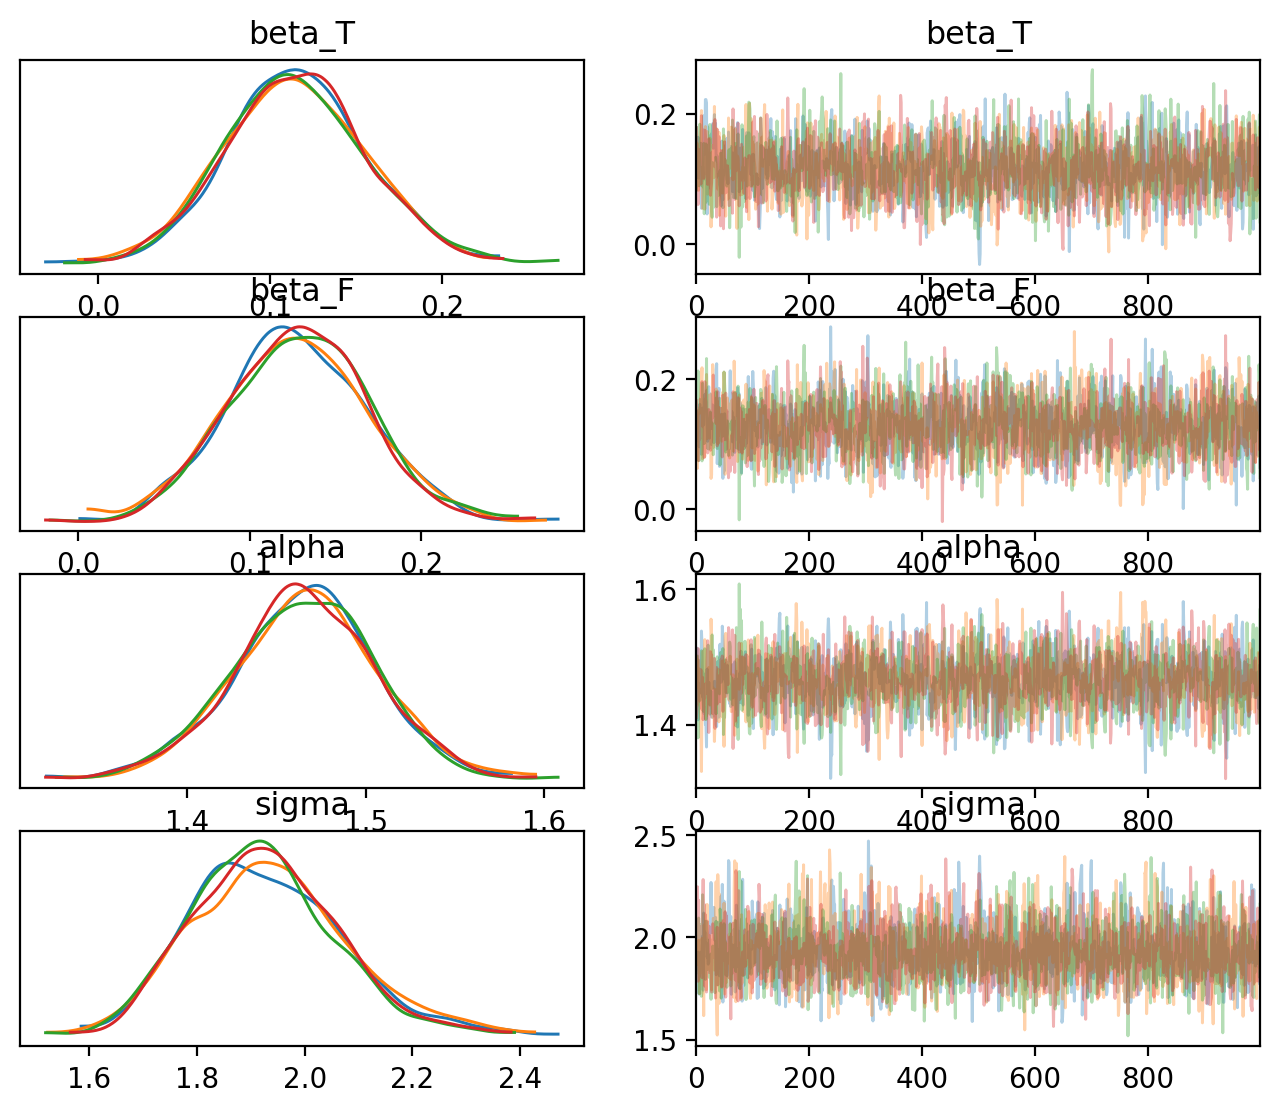

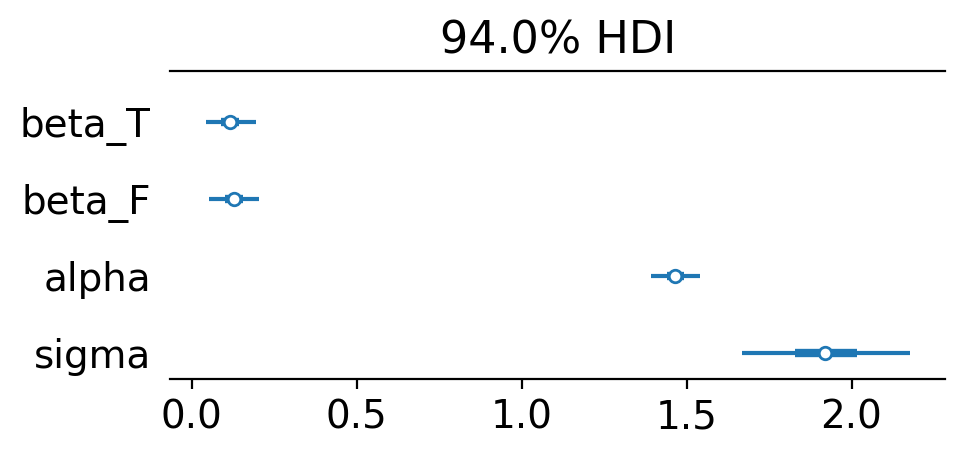

In [ ]:
var_names = ['beta_T', 'beta_F', 'alpha', 'sigma']
display(pm.summary(_H1_H0TF_posterior, var_names=var_names))
az.plot_trace(_H1_H0TF_posterior, var_names, compact=False, figsize=(8, 1.6*len(var_names)))
az.plot_forest(_H1_H0TF_posterior, var_names=var_names, combined=True, figsize=[5, 2]);

The above seems to tell us that fungus helps the plants grow! Look at $\beta_F$. This time treatment should not affect growth.

Does this agree with $\beta_T$?

### Linear model (treatment only)

There is no moisture predictor in the model, only the data has changed.

In [ ]:
with pm.Model() as model_H1_H0T:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Lognormal('alpha', mu=0, sigma=0.25)
    beta_T = pm.Normal('beta_T', mu=0, sigma=0.5)
    p = pm.Deterministic('p', alpha + beta_T*treatment)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0T_posterior = pm.sample(1000, tune=1000, cores=4)
H1_H0T_posterior = _H1_H0T_posterior.posterior.to_dataframe()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_T,0.064,0.038,-0.006,0.141,0.001,0.001,2258.0,2495.0,1.0
alpha,1.555,0.027,1.505,1.604,0.001,0.000,2426.0,2539.0,1.0
sigma,2.001,0.142,1.729,2.253,0.003,0.002,2273.0,2244.0,1.0


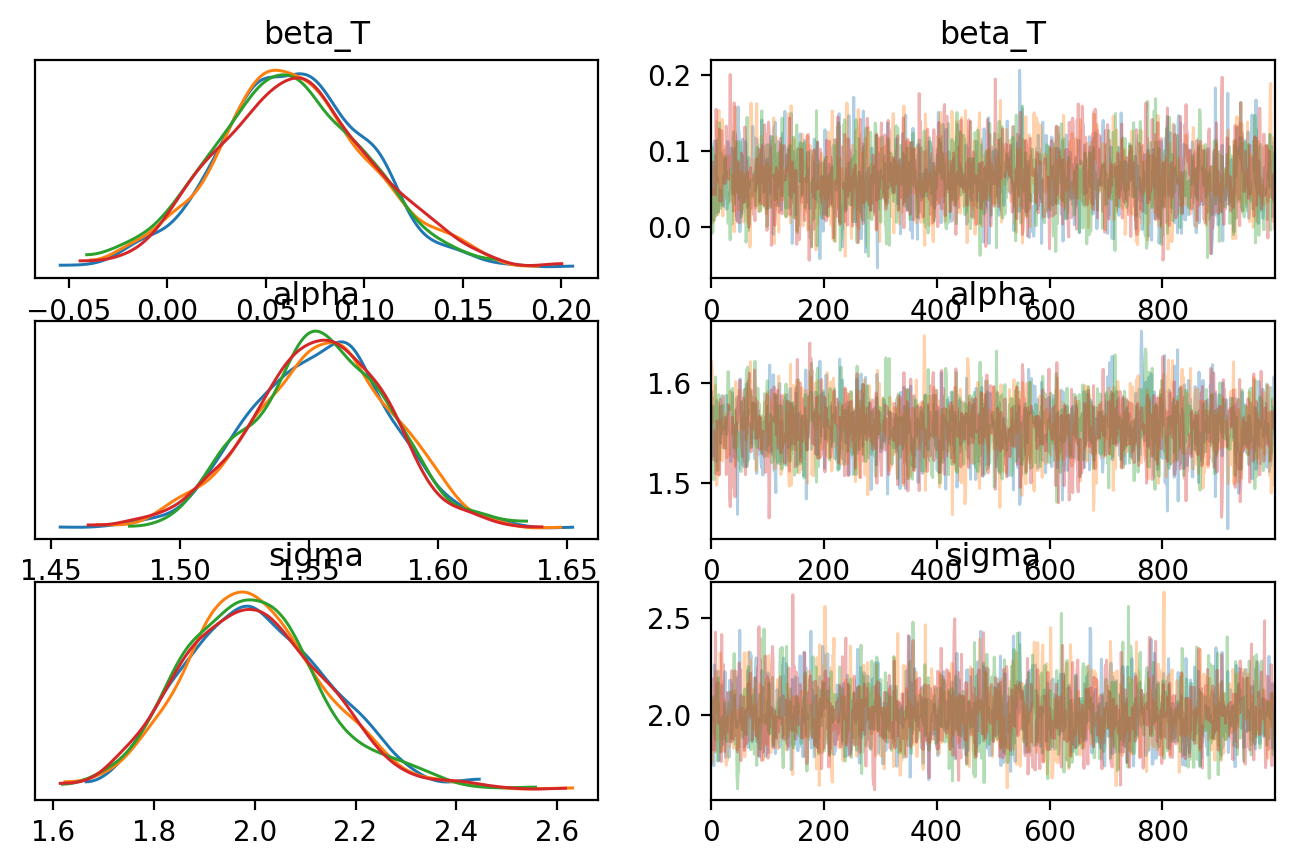

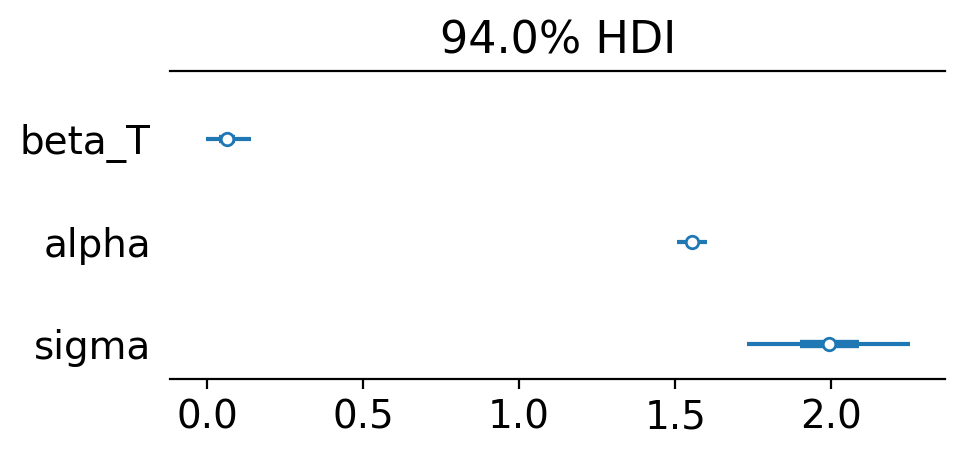

In [ ]:
var_names = ['beta_T', 'alpha', 'sigma']
display(pm.summary(_H1_H0T_posterior, var_names=var_names))
az.plot_trace(_H1_H0T_posterior, var_names, compact=False, figsize=(8, 1.6*len(var_names)))
az.plot_forest(_H1_H0T_posterior, var_names=var_names, combined=True, figsize=[5, 2]);

The above tells us that removing the conditioning on presence of fungus still tells us that treatment has no association with growth, as expected.

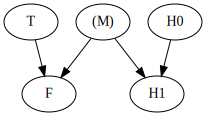

In [ ]:
anti_fungal2 = CausalGraphicalModel(
    nodes=['H0', 'H1', 'F', 'T', '(M)'], edges=[('H0', 'H1'), ('T', 'F'), ('(M)', 'H1'), ('(M)', 'F')]
)
anti_fungal2.draw()

### Summary:

Conditioning on $F$ opens a path from $H_1$ to $T$
This is an example of **collider bias**, fungus is the collider. Conditioning on $F$ opens a path between $H_1$ and $T$.



## Journal review example

**Trustworthiness, Newsworthiness, and Selection of research grants**

> It seems like the most newsworthy scientific studies are the least trustworthy.

The model is that trustworthiness (T) and news-worthiness (N) are statistically independent in the population research proposals submitted to grant review panels. Both of them influence selection (S) for funding. The fact that two arrows enter S means it is a collider.

> When you condition on a collider, it creates statistical—but not necessarily causal-associations among its causes.

The path through a collider is closed unless we condition on the collider variable (in this case $S$). Conditioning on $S$ opens the path between $T$ and $N$, creating spurious correlation between them.

**Note that this is the opposite of the age, marriage, divorce relationship in our first example. The arrows are pointing in the opposite direction.**

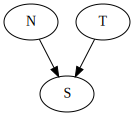

In [ ]:
CausalGraphicalModel(
    nodes=['T', 'S', 'N'], edges=[('T', 'S'), ('N', 'S')]
).draw()

### Simulated data

In [ ]:
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = normal(size=N)
tw = normal(size=N)
# select top 10% of combined scores
score = nw + tw  # total score
q = quantile(score, 1 - p)  # top 10% threshold
selected = score >= q
cor = corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.55243819],
       [-0.55243819,  1.        ]])

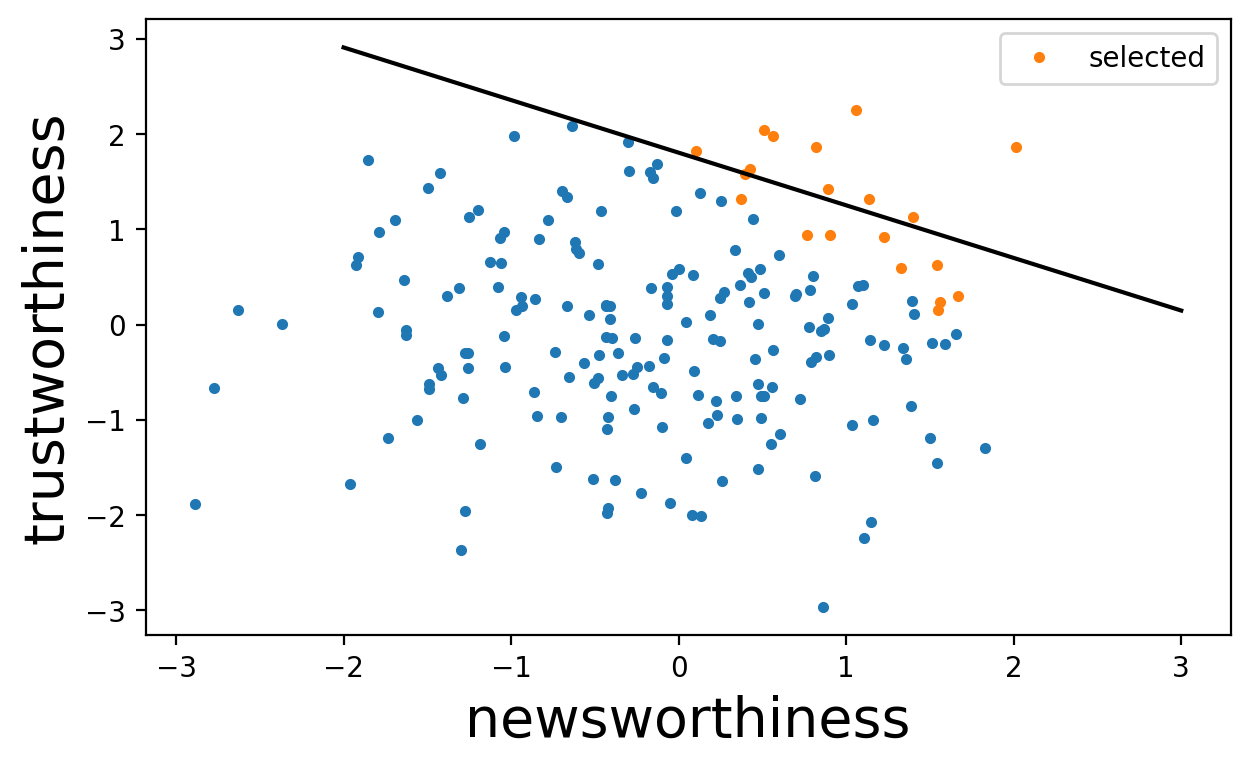

In [ ]:
figure(1, [7, 4])

plot(nw[selected == False], tw[selected == False], '.')
plot(nw[selected], tw[selected], '.', label='selected')
legend()

# correlation line
xn = array([-2, 3])
plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()), 'k')

xlabel('newsworthiness', fontsize=20)
ylabel('trustworthiness', fontsize=20);

### Summary:

Conditioning on a collider variable opens a path between two variables

# The four elemental confounds
  1. The Fork
  2. The Pipe
  3. The Collider
  4. The Descendant
  
Think of situations where we want to predict outcome variable Y with predictor variable X

## Definition: A Path

A path between two nodes is given by following the arrows from one node to another, **ignoring the direction of the arrows**

### 1. Fork

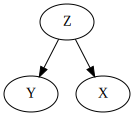

In [ ]:
CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'], edges=[('Z', 'X'), ('Z', 'Y')]
).draw()

Path from X to Y is open, can be closed by conditioning on Z

### 2. Pipe

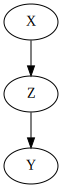

In [ ]:
CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'], edges=[('X', 'Z'), ('Z', 'Y')]
).draw()

Path from X to Y is open, can be closed by conditioning on Z

### 3. Collider

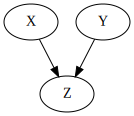

In [ ]:
CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'], edges=[('X', 'Z'), ('Y', 'Z')]
).draw()

Path from X to Y is closed, can be opened by conditioning on Z

### 4. Descendant

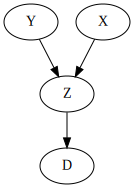

In [ ]:
CausalGraphicalModel(
    nodes=['X', 'Y', 'Z', 'D'], edges=[('X', 'Z'), ('Y', 'Z'), ('Z', 'D')]
).draw()

Path from X to Y is closed, can be opened by conditioning on Z or on D

## Example: Removing confounds in a DAG

Assume that we want to predict outcome $Y$ with predictor $X$.


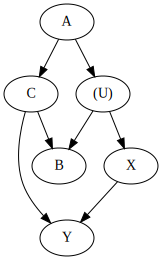

In [ ]:
CausalGraphicalModel(
    nodes=['A', 'B', 'C', 'X', 'Y', '(U)'],
    edges=[('X', 'Y'), ('(U)', 'X'), ('(U)', 'B'), ('A', '(U)'), ('A', 'C'), ('C', 'B'), ('C', 'Y')]
).draw()

Look for "backdoor" paths (arrows going into $X$)

There should be two additional "backdoor" paths

  1. $X \leftarrow (U) \rightarrow B \leftarrow C \rightarrow Y$
  2. $X \leftarrow (U) \leftarrow A \rightarrow C \rightarrow Y$

- Are the paths "open" or "closed"?
- If any are open, how do we close it?

## Example: Backdoor waffles

  1. S is whether the state is in the "South"
  2. W is the number of Waffle Houses
  3. D is divorce rate
  4. M is marriage rate
  5. A is median age at marriage
  
We want to understand the effect of W on D

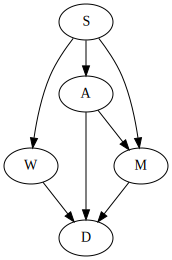

In [ ]:
CausalGraphicalModel(
    nodes=['A', 'D', 'S', 'M', 'W'],
    edges=[('A', 'M'), ('A', 'D'), ('S', 'A'), ('S', 'W'), ('S', 'M'), ('W', 'D'), ('M', 'D')]
).draw()

There are three backdoor paths

  1. $W \leftarrow S \rightarrow A \rightarrow D$
  2. $W \leftarrow S \rightarrow A \rightarrow M \rightarrow D$
  3. $W \leftarrow S \rightarrow M \rightarrow D$